## Linear correlation of non-explicitely encoded variables with observations and LSTM output (panel D)

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from definitions import ROOT_DIR
import sklearn.linear_model
from envs.environment_factory import EnvironmentFactory
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import VecNormalize
from functions_notebook import make_parallel_envs
import pickle

/opt/homebrew/Caskroom/miniforge/base/envs/myochallenge/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


1. Record the observations and LSTM outputs together with hand's velocity and acceleration, ball mass, size and friction, and trajectory radius. __Go to 2. to directly load the previously-obtained data__

In [10]:
PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

config = {
"weighted_reward_keys": {
    "pos_dist_1": 0,
    "pos_dist_2": 0,
    "act_reg": 0,
    "alive": 0,
    "solved": 5,
    "done": 0,
    "sparse": 0
},
"enable_rsi": False,
"rsi_probability": 0,
"balls_overlap": False,
"overlap_probability": 0,
"noise_fingers": 0,
"limit_init_angle": 0,
"goal_time_period": [
    4,
    6
],
"goal_xrange": [
    0.02,
    0.03
],
"goal_yrange": [
    0.022,
    0.032
],
"obj_size_range": [
    0.018,
    0.021
],
"obj_mass_range": [
    0.03,
    0.3
],
"obj_friction_change": [
    0.2,
    0.001,
    2e-05
],
"task_choice": "random"
}

env_name = 'CustomMyoBaodingBallsP2'
render = False

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
    PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
)

# EVALUATE
eval_model = model
eval_env = EnvironmentFactory.create(env_name, **config)   

num_episodes = 500

data_list = []
for n in range(num_episodes) :
    lstm_states = (np.zeros((1, 1, 256)), np.zeros((1, 1, 256)))
    cum_rew = 0
    step = 0
    obs = eval_env.reset()
    episode_starts = torch.ones((1,))
    done = False
    while not done:
        lstm_states_tensor = (torch.tensor(lstm_states[0], dtype=torch.float32).reshape(1, -1), torch.tensor(lstm_states[1], dtype=torch.float32).reshape(1, -1))     
        action, lstm_states = eval_model.predict(
            envs.normalize_obs(obs),
            state=lstm_states,
            episode_start=episode_starts,
            deterministic=True,
        )
        with torch.no_grad():
            features = eval_model.policy.extract_features(torch.tensor(envs.normalize_obs(obs)).reshape(1, -1))
            lstm_out, _ = eval_model.policy.lstm_actor(features, (lstm_states_tensor[0] * (1 - episode_starts), lstm_states_tensor[1] * (1 - episode_starts)))
            layer_1_out = eval_model.policy.mlp_extractor.policy_net[1](eval_model.policy.mlp_extractor.policy_net[0](lstm_out))
            layer_2_out = eval_model.policy.mlp_extractor.policy_net[3](eval_model.policy.mlp_extractor.policy_net[2](layer_1_out))
            action_pred = eval_model.policy._get_action_dist_from_latent(layer_2_out).mode().clip(-1, 1)

        assert np.allclose(action_pred, action), print(action_pred, action)
        next_obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_rew += rewards
        step += 1

        hand_pos = obs[0:23]
        hand_vel = (next_obs[0:23] - hand_pos) / 0.0025
        
        data_point = {
            'episode' : n, 
            'time step': step,
            'observation': envs.normalize_obs(obs),
            "lstm_state_0": np.squeeze(lstm_states[0]),
            "lstm_state_1": np.squeeze(lstm_states[1]),
            "lstm_out": np.squeeze(lstm_out.numpy()),
            "layer_1_out": np.squeeze(layer_1_out.numpy()),
            "layer_2_out": np.squeeze(layer_2_out.numpy()),
            "action": action,
            "mass_1": eval_env.sim.model.body_mass[eval_env.object1_bid],
            "size_1": eval_env.sim.model.geom_size[eval_env.object1_gid][0],
            "mass_2": eval_env.sim.model.body_mass[eval_env.object2_bid],
            "size_2": eval_env.sim.model.geom_size[eval_env.object2_gid][0],
            "friction_0": eval_env.sim.model.geom_friction[eval_env.object1_gid][0],
            "friction_1": eval_env.sim.model.geom_friction[eval_env.object1_gid][1],
            "friction_2": eval_env.sim.model.geom_friction[eval_env.object1_gid][2],
            "x_radius": eval_env.x_radius,
            "y_radius": eval_env.y_radius,
            "task": eval_env.which_task.value,
            "hand_pos": hand_pos,
            "hand_vel": hand_vel
        }
        data_list.append(data_point)
        obs = next_obs
    print("Reward:", cum_rew, "length:", step) 
        
df = pd.DataFrame(data_list)
df.to_hdf(os.path.join(ROOT_DIR, "data", "basecamp", "activation_df.hdf"), key="activations")            


MyoSuite:> Registering Myo Envs
Reward: 125.0 length: 200
Reward: 555.0 length: 200
Reward: 275.0 length: 200
Reward: 750.0 length: 200
Reward: 0.0 length: 106
Reward: 0.0 length: 58
Reward: 270.0 length: 200
Reward: 400.0 length: 200
Reward: 350.0 length: 200
Reward: 580.0 length: 200
Reward: 60.0 length: 200
Reward: 430.0 length: 200
Reward: 135.0 length: 200
Reward: 835.0 length: 200
Reward: 620.0 length: 200
Reward: 555.0 length: 200
Reward: 600.0 length: 200
Reward: 750.0 length: 200
Reward: 315.0 length: 200
Reward: 340.0 length: 200
Reward: 830.0 length: 200
Reward: 900.0 length: 200
Reward: 0.0 length: 200
Reward: 160.0 length: 95
Reward: 315.0 length: 200
Reward: 570.0 length: 200
Reward: 965.0 length: 200
Reward: 345.0 length: 200
Reward: 300.0 length: 200
Reward: 580.0 length: 200
Reward: 585.0 length: 200
Reward: 435.0 length: 200
Reward: 0.0 length: 200
Reward: 945.0 length: 200
Reward: 340.0 length: 200
Reward: 530.0 length: 200
Reward: 940.0 length: 200
Reward: 415.0 len

/var/folders/fr/0tbfm7mj1_v8gcjbvtcr_92r0000gn/T/ipykernel_14471/2027431341.py:136: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['observation', 'lstm_state_0', 'lstm_state_1', 'lstm_out',
       'layer_1_out', 'layer_2_out', 'action', 'hand_pos', 'hand_vel'],
      dtype='object')]

  df.to_hdf(os.path.join(ROOT_DIR, "data", "basecamp", "activation_df.hdf"), key="activations")


2. Load the data

In [2]:
# # Load the file from Basecamp : 'lin_corr'
# params = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "lin_corr"),'rb'))

# M=params['Mass']
# Ra=params['Radius']
# Fr=params['Friction']
# S=params['Size']
# VEL=params['Velocity']
# ACC=params['Acceleration']
# OBS=params['Observations']
# LSTM=params['LSTM']

3. __Go to 4. to directly access the previously-obtained data.__\
a. Compute the linear regression and the associated coefficient of determination\
b. Save the data 

In [6]:
# regression = sklearn.linear_model.LinearRegression()

# R_lstm = {'hand velocity':None,'hand acceleration':None,'mass':None,'size':None,'friction':None,'radius':None}
# R_obs = {'hand velocity':None,'hand acceleration':None,'mass':None,'size':None,'friction':None,'radius':None}

# layers = [OBS,LSTM]
# R = [R_obs,R_lstm]

# for i in range(len(R)):

#     lin_model = regression.fit(y=VEL,X=layers[i])
#     R[i]['hand velocity'] = np.round(lin_model.score(y=VEL,X=layers[i]),5)

#     lin_model = regression.fit(y=ACC,X=layers[i])
#     R[i]['hand acceleration'] = np.round(lin_model.score(y=ACC,X=layers[i]),5)

#     lin_model = regression.fit(y=M,X=layers[i])
#     R[i]['mass'] = np.round(lin_model.score(X=layers[i],y=M),5)

#     lin_model = regression.fit(y=S,X=layers[i])
#     R[i]['size'] = np.round(lin_model.score(y=S,X=layers[i]),5)

#     lin_model = regression.fit(y=Fr,X=layers[i])
#     R[i]['friction'] = np.round(lin_model.score(y=Fr,X=layers[i]),5)

#     lin_model = regression.fit(y=Ra,X=layers[i])
#     R[i]['radius'] = np.round(lin_model.score(y=Ra,X=layers[i]),5)

# for R_layer in R : 
#     print(R_layer)

# fp = ".csv"
# pd.DataFrame(R).to_csv(os.path.join(ROOT_DIR,fp))

{'hand velocity': 0.67282, 'hand acceleration': 0.43767, 'mass': 0.76064, 'size': 0.62964, 'friction': 0.06882, 'radius': 0.15411}
{'hand velocity': 0.68337, 'hand acceleration': 0.53705, 'mass': 0.62893, 'size': 0.33984, 'friction': 0.07743, 'radius': 0.2329}


4. Load the previously-obtained R squared

In [3]:
# # Load the file from Basecamp : 'v2_32_phase_2_smaller_rate_resume.csv'
# R = pd.read_csv(os.path.join(ROOT_DIR,"SIL-Results/Linear-correlation/v2_32_phase_2_smaller_rate_resume.csv"))

# Load the dataset and run linear regressions

In [11]:
df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "basecamp", "activation_df.hdf"))
df.keys()

Index(['episode', 'time step', 'observation', 'lstm_state_0', 'lstm_state_1',
       'lstm_out', 'layer_1_out', 'layer_2_out', 'action', 'mass_1', 'size_1',
       'mass_2', 'size_2', 'friction_0', 'friction_1', 'friction_2',
       'x_radius', 'y_radius', 'task', 'hand_pos', 'hand_vel'],
      dtype='object')

In [32]:
results_list = []
regression = sklearn.linear_model.LinearRegression()
for target in ["mass_1", "mass_2", "size_1", "size_2", "friction_0", "friction_1", "friction_2", "x_radius", "y_radius"]:
    for key in ["observation", "lstm_state_0", "lstm_state_1", "lstm_out", "layer_1_out", "layer_2_out", "action"]:
        X = np.array(df[key].to_list())
        y = df[target].to_numpy()

        lin_model = regression.fit(X, y)
        score = regression.score(X, y)
        print("Key:", key, " target:", target,  "score:", score)
        results_list.append({"input": key, "target": target, "score": score})

Key: observation  target: mass_1 score: 0.6014780961638331
Key: lstm_state_0  target: mass_1 score: 0.4002796380726923
Key: lstm_state_1  target: mass_1 score: 0.4815046604210743
Key: lstm_out  target: mass_1 score: 0.4002796380726923
Key: layer_1_out  target: mass_1 score: 0.2703575384802077
Key: layer_2_out  target: mass_1 score: 0.1979296979149544
Key: action  target: mass_1 score: 0.1098858011006083
Key: observation  target: mass_2 score: 0.6014780961638331
Key: lstm_state_0  target: mass_2 score: 0.4002796380726923
Key: lstm_state_1  target: mass_2 score: 0.4815046604210743
Key: lstm_out  target: mass_2 score: 0.4002796380726923
Key: layer_1_out  target: mass_2 score: 0.2703575384802077
Key: layer_2_out  target: mass_2 score: 0.1979296979149544
Key: action  target: mass_2 score: 0.1098858011006083
Key: observation  target: size_1 score: 0.49987329310299256
Key: lstm_state_0  target: size_1 score: 0.14311420496123572
Key: lstm_state_1  target: size_1 score: 0.19795983599438927
Key:

In [33]:
classification = sklearn.linear_model.LogisticRegression(max_iter=10_000)
target = "task"
for key in ["observation", "lstm_state_0", "lstm_state_1", "lstm_out", "layer_1_out", "layer_2_out", "action"]:
    X = np.array(df[key].to_list())
    y = df[target].to_numpy()

    lin_model = classification.fit(X, y)
    score = classification.score(X, y)
    print("Key:", key, " target:", target,  "score:", score)
    results_list.append({"input": key, "target": target, "score": score})

Key: observation  target: task score: 0.6523197715917202
Key: lstm_state_0  target: task score: 0.7209544203120221
Key: lstm_state_1  target: task score: 0.7526460691342919
Key: lstm_out  target: task score: 0.7209544203120221
Key: layer_1_out  target: task score: 0.6517793412868359
Key: layer_2_out  target: task score: 0.5998674416233303
Key: action  target: task score: 0.4837259100642398


In [34]:
regression = sklearn.linear_model.LinearRegression()
for target in ["hand_pos", "hand_vel"]:
    for key in ["observation", "lstm_state_0", "lstm_state_1", "lstm_out", "layer_1_out", "layer_2_out", "action"]:
        X = np.array(df[key].to_list())
        y = np.array(df[target].to_list())

        lin_model = regression.fit(X, y)
        score = regression.score(X, y)
        print("Key:", key, " target:", target,  "score:", score)
        results_list.append({"input": key, "target": target, "score": score})

Key: observation  target: hand_pos score: 0.999977939322048
Key: lstm_state_0  target: hand_pos score: 0.8088651340321189
Key: lstm_state_1  target: hand_pos score: 0.8534043116001905
Key: lstm_out  target: hand_pos score: 0.8088651340321189
Key: layer_1_out  target: hand_pos score: 0.6601694794096882
Key: layer_2_out  target: hand_pos score: 0.5679796470583713
Key: action  target: hand_pos score: 0.3646771509707263
Key: observation  target: hand_vel score: 0.6650418166800506
Key: lstm_state_0  target: hand_vel score: 0.6080585483808639
Key: lstm_state_1  target: hand_vel score: 0.6279614433493995
Key: lstm_out  target: hand_vel score: 0.6080585483808639
Key: layer_1_out  target: hand_vel score: 0.5414458173394989
Key: layer_2_out  target: hand_vel score: 0.527320179672779
Key: action  target: hand_vel score: 0.3783807303066516


In [38]:
results_df = pd.DataFrame(results_list)
results_df

,input,target,score
0,observation,mass_1,0.601478
1,lstm_state_0,mass_1,0.400280
2,lstm_state_1,mass_1,0.481505
3,lstm_out,mass_1,0.400280
4,layer_1_out,mass_1,0.270358
...,...,...,...
79,lstm_state_1,hand_vel,0.627961
80,lstm_out,hand_vel,0.608059
81,layer_1_out,hand_vel,0.541446
82,layer_2_out,hand_vel,0.527320


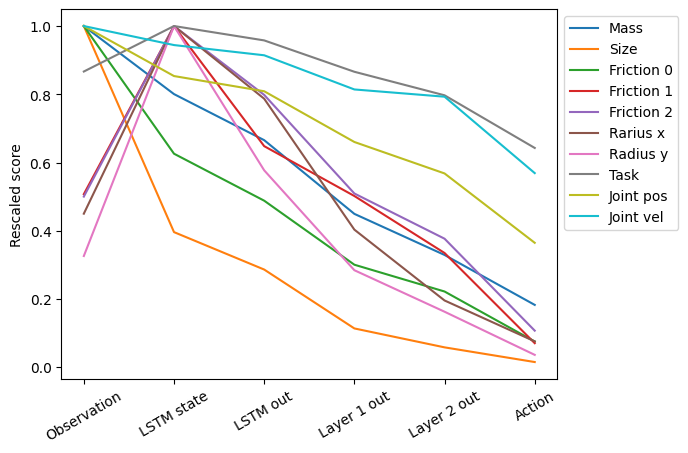

In [61]:
import matplotlib.pyplot as plt


layers_list = ["observation", "lstm_state_1", "lstm_out", "layer_1_out", "layer_2_out", "action"]
layers_name_list = ["Observation", "LSTM state", "LSTM out", "Layer 1 out", "Layer 2 out", "Action"]
targets_list = ["mass_1", "size_1", "friction_0", "friction_1", "friction_2", "x_radius", "y_radius", "task", "hand_pos", "hand_vel"]
targets_name_list = ["Mass", "Size", "Friction 0", "Friction 1", "Friction 2", "Rarius x", "Radius y", "Task", "Joint pos", "Joint vel"]

fig, ax = plt.subplots(1)
for target, target_name in zip(targets_list, targets_name_list):
    score_list = []
    for layer in layers_list:
        score = results_df[(results_df.input == layer) & (results_df.target == target)].score.item()
        score_list.append(score)
    score_vec = np.array(score_list) / max(score_list)
    ax.plot(score_vec, label=target_name)
ax.legend()
ax.set_xticks(range(6), labels=layers_name_list, rotation=30)
ax.set_ylabel("Rescaled score")
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_4", "layer_encoding.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()
    

In [47]:
layers_list

['observation',
 'lstm_state_0',
 'lstm_state_1',
 'lstm_out',
 'layer_1_out',
 'layer_2_out',
 'action']